**Импорт необходимых библиотек и установка зерна для генераторов случайных чисел**

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets
from tqdm.auto import tqdm
import time
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.cuda.empty_cache()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Загрузка датасета CIFAR10**

In [ ]:
CIFAR_train=torchvision.datasets.CIFAR10('./',download=True,train=True)
CIFAR_test=torchvision.datasets.CIFAR10('./',download=True,train=False)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


**Преобразование датасетов к формату torch-тензоров**

In [ ]:
X_train=torch.FloatTensor(CIFAR_train.data)
Y_train=torch.LongTensor(CIFAR_train.targets)
X_test=torch.FloatTensor(CIFAR_test.data)
Y_test=torch.LongTensor(CIFAR_test.targets)
X_train=X_train/255
X_test=X_test/255

**Примеры изображений из датасета**

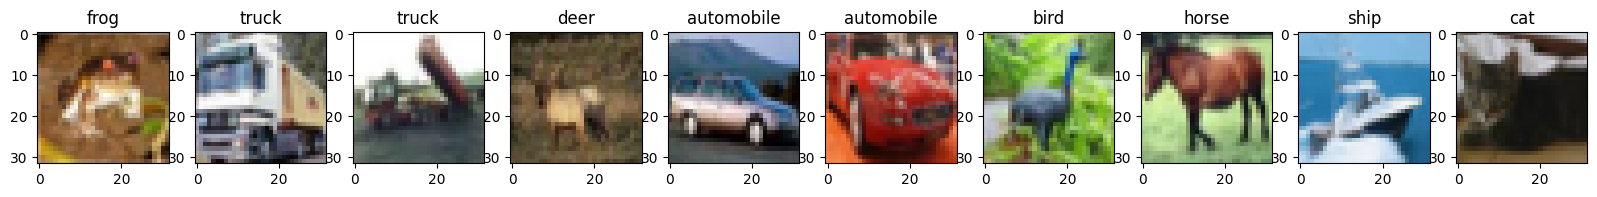

In [ ]:
plt.figure(figsize=(20,2))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(X_train[i])
  plt.title(CIFAR_train.classes[Y_train[i].item()])

**Преобразование тензоров для входов нейросети**

In [ ]:
X_train=X_train.permute(0,3,1,2)
X_test=X_test.permute(0,3,1,2)

**Архитектура нейросети для тестирования** <br>
*В метод `__init__()` можно передавать разные параметры для разных слоёв и тем самым модифицировать архитектуру модели*

In [ ]:
class Netty(torch.nn.Module):
  def __init__(self,
               conv1=6,
               conv2=12,
               conv3=None,
               fc1=256,
               fc2=None
               ):
    super(Netty,self).__init__()

    #batch_norm_0
    self.batch_norm_0=torch.nn.BatchNorm2d(3)

    #conv_1
    self.conv_1=torch.nn.Conv2d(3,conv1,3,padding=1)
    self.act_1=torch.nn.ReLU()
    self.batch_norm_1=torch.nn.BatchNorm2d(conv1)
    self.pool_1=torch.nn.MaxPool2d(2,2)

    #conv_2
    self.conv_2=torch.nn.Conv2d(conv1,conv2,3,padding=1)
    self.act_2=torch.nn.ReLU()
    self.batch_norm_2=torch.nn.BatchNorm2d(conv2)
    self.pool_2=torch.nn.MaxPool2d(2,2)

    #conv_3
    if conv3:
      self.conv_3=torch.nn.Conv2d(conv2,conv3,3,padding=1)
      self.act_3=torch.nn.ReLU()
      self.batch_norm_3=torch.nn.BatchNorm2d(conv3)
      self.pool_3=torch.nn.MaxPool2d(2,2)
    else:
      self.conv_3=None

    #fc_1
    n=conv3*4*4 if conv3 else conv2*8*8
    self.fc_1=torch.nn.Linear(n,fc1)
    self.act_4=torch.nn.ReLU()
    self.batch_norm_4=torch.nn.BatchNorm1d(fc1)

    #fc2 and fc3
    if fc2:
      self.fc_2=torch.nn.Linear(fc1,fc2)
      self.act_5=torch.nn.ReLU()
      self.batch_norm_5=torch.nn.BatchNorm1d(fc2)
      self.fc_3=torch.nn.Linear(fc2,10)
    else:
      self.fc_2=torch.nn.Linear(fc1,10)
      self.fc_3=None

  def forward(self,x):

    x=self.batch_norm_0(x)

    x=self.conv_1(x)
    x=self.act_1(x)
    x=self.batch_norm_1(x)
    x=self.pool_1(x)

    x=self.conv_2(x)
    x=self.act_2(x)
    x=self.batch_norm_2(x)
    x=self.pool_2(x)

    if self.conv_3 is not None:
       x=self.conv_3(x)
       x=self.act_3(x)
       x=self.batch_norm_3(x)
       x=self.pool_3(x)
    x=x.reshape(x.size(0),x.size(1)*x.size(2)*x.size(3))

    x=self.fc_1(x)
    x=self.act_4(x)
    x=self.batch_norm_4(x)

    if self.fc_3 is not None:
      x=self.fc_2(x)
      x=self.batch_norm_5(x)
      x=self.fc_3(x)
    else:
      x=self.fc_2(x)

    return x

**Кастормный training loop**

In [ ]:
def train(net:Netty,xtrain,ytrain,xtest,ytest,bs=25):
  max_accuracy=0
  net=net.to(device)
  loss=torch.nn.CrossEntropyLoss()
  optimizer=torch.optim.Adam(net.parameters(),lr=1e-3)
  epochs=10
  for _ in tqdm(range(epochs),f"Train {len(accuracies)}",position=7,leave=False):
    order=np.random.permutation(len(xtrain))
    for start in range(0,len(xtrain),bs):
      optimizer.zero_grad()
      net.train()
      indexes=order[start:start+bs]
      X=xtrain[indexes].to(device)
      Y=ytrain[indexes].to(device)
      pred=net(X)
      loss_value=loss(pred,Y)
      loss_value.backward()
      optimizer.step()
    xtest=xtest.to(device)
    ytest=ytest.to(device)
    net.eval()
    test_pred=net(xtest)
    accuracy=(test_pred.argmax(dim=1)==ytest).float().mean().data.cpu().item()
    if accuracy>max_accuracy:
      max_accuracy=accuracy
      if accuracy>global_accuracy[0]:
        global_accuracy[0]=accuracy
        # temp=torch.jit.script(net)
        # torch.jit.save(temp,"./Netty.pt")
  return max_accuracy,sum([p.numel() for p in net.parameters() if p.requires_grad])


**Гиперпараметры для тестирования**

In [ ]:
conv1=[8,32]
conv2=[16,64]
conv3=[None,32,128]
fc1=[128]
fc2=[None,32]
bs=[25,100]

**Массивы для сохранения метрик**

In [ ]:
accuracies={}
times={}
n_params={}
global_accuracy=[0]

**Кастомная кросс-валидация** <br>
*Обучаем несколько моделей с разными параметрами, сравниваем их метрики и отбираем модели с лучшими показателями* <br>
(Всего получилось 48 моделей)

In [ ]:
def custom_cross_validation():
  for c1 in tqdm(range(len(conv1)),"Conv_1",position=0,leave=False):
    for c2 in tqdm(range(len(conv2)),"Conv_2",position=1,leave=False):
      for c3 in tqdm(range(len(conv3)),"Conv_3",position=2,leave=False):
        for f1 in tqdm(range(len(fc1)),"FC_1",position=3,leave=False):
          for f2 in tqdm(range(len(fc2)),"FC_2",position=4,leave=False):
            for bsize in tqdm(range(len(bs)),"Batch_size",position=5,leave=False):
              start=time.time()
              acc,n=train(Netty(conv1[c1],conv2[c2],conv3[c3],fc1[f1],fc2[f2]),
                          X_train,Y_train,X_test,Y_test,bs[bsize])
              stop=time.time()
              t=round(stop-start,2)
              index=f"{conv1[c1]} {conv2[c2]} {conv3[c3]} {fc1[f1]} {fc2[f2]} {bs[bsize]}"
              accuracies[index]=acc
              n_params[index]=n
              times[index]=t
              torch.cuda.empty_cache()


In [ ]:
custom_cross_validation()

**Результаты кросс-валидации**

In [ ]:
for k in accuracies.keys():
  print(k,"    ",round(accuracies[k],3),"     ",times[k],"    ",n_params[k])

8 16 None 128 None 25      0.705       65.08      134192
8 16 None 128 None 100      0.69       19.01      134192
8 16 None 128 32 25      0.698       70.23      137424
8 16 None 128 32 100      0.679       20.38      137424
8 16 32 128 None 25      0.727       74.19      73360
8 16 32 128 None 100      0.71       21.68      73360
8 16 32 128 32 25      0.722       81.21      76592
8 16 32 128 32 100      0.712       23.43      76592
8 16 128 128 None 25      0.734       74.29      284080
8 16 128 128 None 100      0.711       22.96      284080
8 16 128 128 32 25      0.742       81.41      287312
8 16 128 128 32 100      0.713       24.59      287312
8 64 None 128 None 25      0.712       63.93      531008
8 64 None 128 None 100      0.7       22.04      531008
8 64 None 128 32 25      0.718       71.29      534240
8 64 None 128 32 100      0.695       23.35      534240
8 64 32 128 None 25      0.749       75.36      90784
8 64 32 128 None 100      0.736       25.31      90784
8 64 32

**Отбор наиболее интересных моделей**

In [ ]:
min_params=["1",1e9]
min_time=["1",1e9]
max_accuracy=["1",0]
for k in accuracies.keys():
  if n_params[k]<min_params[1]:
    min_params[0]=k
    min_params[1]=n_params[k]
  if times[k]<min_time[1]:
    min_time[0]=k
    min_time[1]=times[k]
  if accuracies[k]>max_accuracy[1]:
    max_accuracy[0]=k
    max_accuracy[1]=accuracies[k]



In [ ]:
print(min_params)
print(min_time)
print(max_accuracy)

['8 16 32 128 None 25', 73360]
['8 16 None 128 None 100', 19.01]
['32 64 128 128 32 25', 0.7890999913215637]


*Вспомогательная функция для показа архитектуры модели*

In [ ]:
def show_model(arc:str):
  arc=arc.split()
  print("Short architecture:")
  print("Conv_1",f"(3,{arc[0]})")
  print("Conv_2",f"({arc[0]},{arc[1]})")
  print("Conv_3",f"({arc[1]},{arc[2]})" if arc[2]!="None" else "None" )
  n=4*4*int(arc[2]) if arc[2]!="None" else 8*8*int(arc[1])
  print("FC_1",f"({n},{arc[3]})")
  n=arc[4] if arc[4]!="None" else 10
  print("FC_2",f"({arc[3]},{n})")
  print("FC_3",f"({n},10)" if n!=10 else "None")
  print()

*Самая "легковесная" модель (с наименьшим числом параметров)*

In [ ]:
i1=min_params[0]
show_model(i1)
i2=" ".join(min_params[0].split()[:-1]+["100"])
print(f"Number of parameters: {n_params[i1]}")
print(f"Learning time: {times[i1]} (batch_size 25);  {times[i2]} (batch_size 100)")
print(f"Accuracy: {round(accuracies[i1],3)} (batch_size 25);  {round(accuracies[i2],3)} (batch_size 100)")

Short architecture:
Conv_1 (3,8)
Conv_2 (8,16)
Conv_3 (16,32)
FC_1 (512,128)
FC_2 (128,10)
FC_3 None

Number of parameters: 73360
Learning time: 74.19 (batch_size 25);  21.68 (batch_size 100)
Accuracy: 0.727 (batch_size 25);  0.71 (batch_size 100)


*Самая "быстрообучаемая" модель*

In [ ]:
i1=min_time[0]
show_model(i1)
i2=" ".join(min_time[0].split()[:-1]+["100"])
print(f"Number of parameters: {n_params[i1]}")
print(f"Learning time: {times[i1]} (batch_size 25);  {times[i2]} (batch_size 100)")
print(f"Accuracy: {round(accuracies[i1],3)} (batch_size 25);  {round(accuracies[i2],3)} (batch_size 100)")

Short architecture:
Conv_1 (3,8)
Conv_2 (8,16)
Conv_3 None
FC_1 (1024,128)
FC_2 (128,10)
FC_3 None

Number of parameters: 134192
Learning time: 19.01 (batch_size 25);  19.01 (batch_size 100)
Accuracy: 0.69 (batch_size 25);  0.69 (batch_size 100)


*Cамая "точная" модель*

In [ ]:
i1=max_accuracy[0]
show_model(i1)
i2=" ".join(min_params[0].split()[:-1]+["100"])
print(f"Number of parameters: {n_params[i1]}")
print(f"Learning time: {times[i1]} (batch_size 25);  {times[i2]} (batch_size 100)")
print(f"Accuracy: {round(accuracies[i1],3)} (batch_size 25);  {round(accuracies[i2],3)} (batch_size 100)")

Short architecture:
Conv_1 (3,32)
Conv_2 (32,64)
Conv_3 (64,128)
FC_1 (2048,128)
FC_2 (128,32)
FC_3 (32,10)

Number of parameters: 360752
Learning time: 83.08 (batch_size 25);  21.68 (batch_size 100)
Accuracy: 0.789 (batch_size 25);  0.71 (batch_size 100)
